In [59]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import descartes

In [60]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

## 1 LOADING DATASETS and DATA PROCESSING

In [61]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

In [9]:
print('Number of Training Examples = ', len(stores_train['store_id']))
print('Number of Test Examples = ', len(stores_test['store_id']))
print('Training X Shape = {}\n'.format(stores_train.shape))
print('Training y Shape = ', stores_train['revenue'].shape[0])
print('Test X Shape = {}'.format(stores_test.shape))
print('Test y Shape = {}\n'.format(stores_test.shape[0]))

Number of Training Examples =  12859
Number of Test Examples =  8577
Training X Shape = (12859, 12)

Training y Shape =  12859
Test X Shape = (8577, 11)
Test y Shape = 8577



### **Features description**

The `stores_train.csv` dataset is the basis for your training data and contains 12859 rows. 
Each store (row) is associated with the following information:
- `store_id`: unique ID for each store 
- `year`: The year the data is recorded for (should all be 2016)
- `store_name`: Human readable name for each store
- `plaace_hierarchy_id`: Group ID for the store type (see [Place Hierarchy](#Plaace-Hierarchy))
- `sales_channel_name`: Human readable name for the store type 
- `grunnkrets_id`: Geographical ID for the store's location (see [Grunnkrets Data](#Grunnkrets-Data))
- `address`: Street address of the store 
- `lat`: Latitude (north-south) coordinate for the store's location 
- `lon`: Longitude (west-east) coordinate for the store's location 
- `chain_name`: Name of the chain the store belongs to (if available)
- `mall_name`: Name of the mall a store is located in (if available)
- `revenue` (**target**): The store's revenue in 2016. This is what you will be predicting.

We looked a bit at what the data looks like before we started performing transformations and using the dataset for the models.

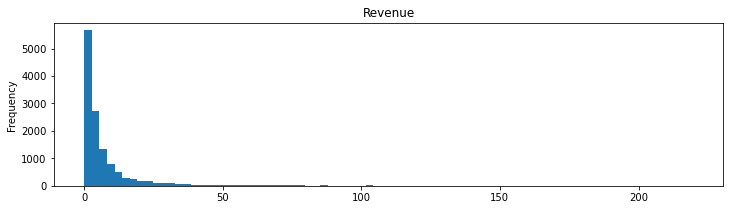

In [10]:
fig, ax = plt.subplots(figsize=(12, 3))
stores_train.revenue.plot.hist(bins=80, ax=ax)
ax.set_title('Revenue');

The lower the revenue value, the more frequent it is. In other words, very few stores achieve high levels of revenue.

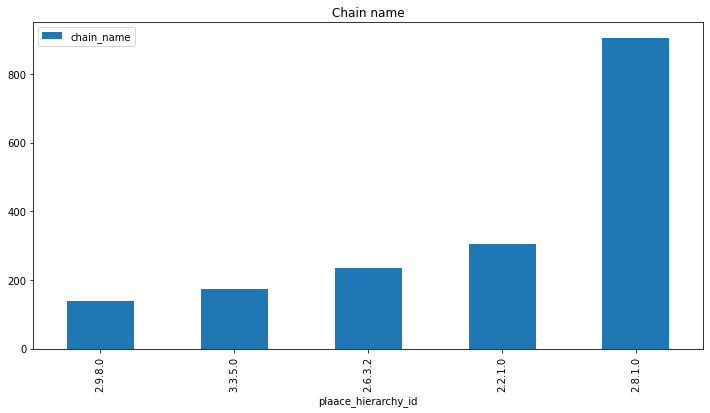

In [19]:
hg = stores_train[['plaace_hierarchy_id','chain_name']].groupby(['plaace_hierarchy_id']).count()
f,ax=plt.subplots(figsize=(12,6))
hg.sort_values('chain_name').tail().plot.bar(ax=ax)
ax.set_title('Chain name')
plt.show()

Text(0.5, 1.0, 'Hierarchy 2.2.1.0')

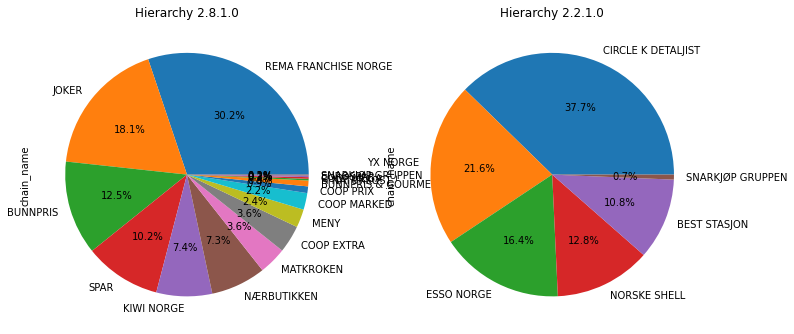

In [20]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
stores_train.loc[stores_train['plaace_hierarchy_id']=='2.8.1.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Hierarchy 2.8.1.0')

stores_train.loc[stores_train['plaace_hierarchy_id']=='2.2.1.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False)
ax[1].set_title('Hierarchy 2.2.1.0')

Text(0.5, 1.0, 'Hierarchy 3.3.5.0')

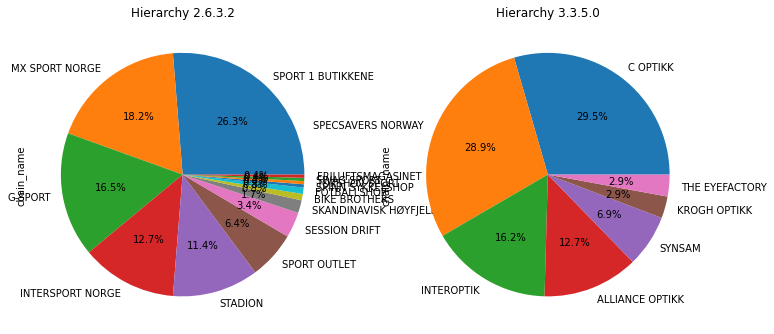

In [21]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
stores_train.loc[stores_train['plaace_hierarchy_id']=='2.6.3.2']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Hierarchy 2.6.3.2')

stores_train.loc[stores_train['plaace_hierarchy_id']=='3.3.5.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False)
ax[1].set_title('Hierarchy 3.3.5.0')

We have counted the chains that belong to the hierarchies with the highest volume of data and we can see that the chains that appear most frequently within each hierarchy are:
- 2.8.1.0 (Grocery stores): REMA FRANCHISE NORGE (30.2%)
- 2.2.1.0 (Gas stations): CIRCLE K DETALJIST (37.7%)
- 2.6.3.2 (Sporting goods stores): SPORT Q BUTIKKENE (26.3%)
- 3.3.5.0 (Opticians): C OPTIKK (29.5%)

### NaN Values

Text(0.5, 1.0, 'Fraction of rows with NaN values')

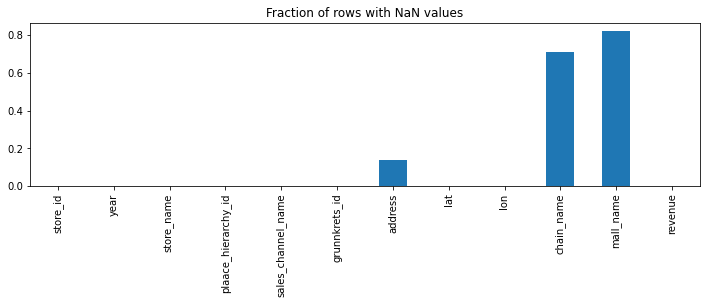

In [22]:
fig, ax = plt.subplots(figsize=(12, 3))
stores_train.isna().mean().plot.bar(ax=ax)
ax.set_title('Fraction of rows with NaN values')

As we can see in the graph above, we have a lot of missing data in the variables chain_name and mall_name and, to a lesser extent, in the variable address. In our case, we have observed that there is a lot of information that can be obtained from other variables (e.g. we can dispense with address by using the latitude and longitude of the stores). Therefore, we have treated the missing data for the chain_name variable.

In [62]:
stores_train['chain_name'].fillna('LOCAL STORE', inplace=True)

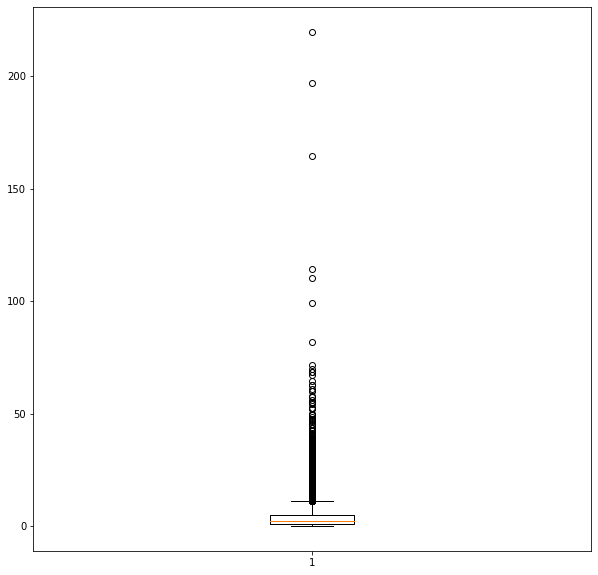

In [24]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax.boxplot(stores_train.loc[stores_train['chain_name'] == 'LOCAL STORE']['revenue'])
plt.show()

We had a large amount of missing data in this variable, so this may have affected the statistics previously obtained, as can be seen below.

Text(0.5, 1.0, 'Hierarchy 2.2.1.0')

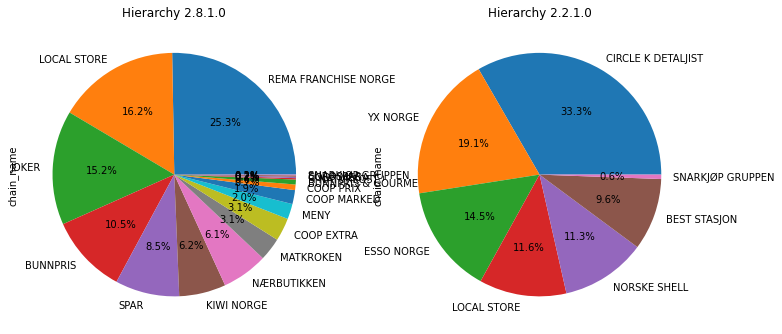

In [25]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
stores_train.loc[stores_train['plaace_hierarchy_id']=='2.8.1.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Hierarchy 2.8.1.0')

stores_train.loc[stores_train['plaace_hierarchy_id']=='2.2.1.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False)
ax[1].set_title('Hierarchy 2.2.1.0')

Text(0.5, 1.0, 'Hierarchy 3.3.5.0')

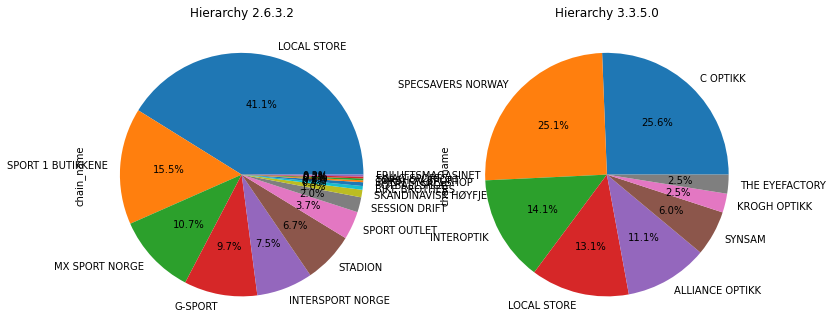

In [26]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
stores_train.loc[stores_train['plaace_hierarchy_id']=='2.6.3.2']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Hierarchy 2.6.3.2')

stores_train.loc[stores_train['plaace_hierarchy_id']=='3.3.5.0']['chain_name'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False)
ax[1].set_title('Hierarchy 3.3.5.0')

Especially in hierarchy 2.6.3.2 (Sporting goods stores) we see that there is a large volume of Local Stores.

## 1.1 Bus stops + train stores + extra stores map
Queremos extraer las latitudes y longitudes de las paradas de bus.

In [63]:
long_stop = []
lat_stop = []
for i in range(len(busstops.geometry)):
    long, lat = busstops.geometry[i].replace("POINT(","").replace(")","").split()
    long_stop.append(float(long))
    lat_stop.append(float(lat))
busstops['lat_stop'] = lat_stop
busstops['long_stop'] = long_stop

The following map will help us to visualize where is every busstop and store, including the extra stores. 
- **Blue:** Busstops
- **Magenta:** Stores

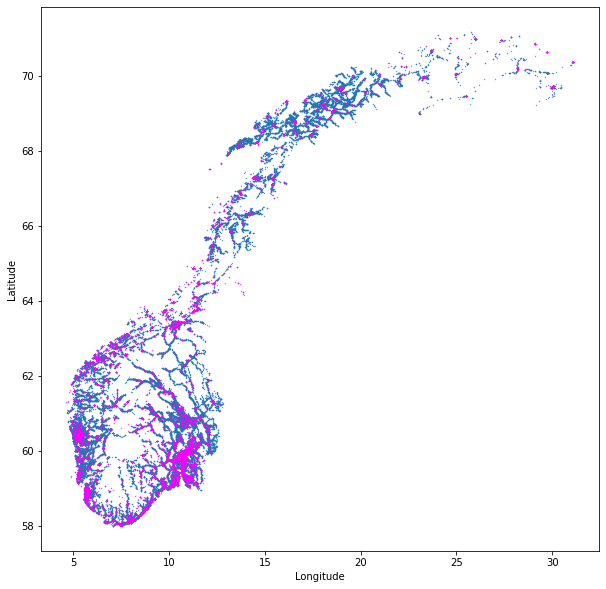

In [64]:
import geopandas
from geopandas import GeoSeries
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

buslat=busstops['lat_stop']
buslon=busstops['long_stop']
y=stores_with_hierarchy.loc[:,'lat']
x=stores_with_hierarchy.loc[:,'lon']
y2=stores_extra.loc[:,'lat']
x2=stores_extra.loc[:,'lon']

plt.figure(figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(buslon,buslat, s=0.1)
plt.scatter(x,y, s=0.1, c='magenta')
plt.scatter(x2,y2, s=0.1, c='magenta')
plt.show()

How many bus stops are within the train stores polygons:

**NOTE:** The run-time for the polygon method was excesive, we will use squares instead.

In [65]:
buspts = zip(buslon, buslat) # column of longitude and column of latitude
buspts = list(buspts) # very important!!! otherwise it won't work!!!

xypts2 = zip(x, y)
xypts2 = list(xypts2)

busstopsnearby = [0]*len(xypts2)
for n,(stlo,stla) in enumerate(xypts2):
    ustla = stla + 0.018001800180018002
    dstla = stla - 0.018001800180018002
    rstlo = stlo + 0.018001800180018002
    lstlo = stlo - 0.018001800180018002
    for blo,bla in buspts:
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            busstopsnearby[n] +=1

Now we check what busstops and how many extra stores are within the train stores polygons:

In [66]:
#extra stores

xtrstpts = zip(x2, y2)
xtrstpts = list(xtrstpts)

xtrstnearby = [0]*len(xypts2)
for n,(stlo,stla) in enumerate(xypts2):
    ustla = stla + 0.018001800180018002/2
    dstla = stla - 0.018001800180018002/2
    rstlo = stlo + 0.018001800180018002/2
    lstlo = stlo - 0.018001800180018002/2
    for blo,bla in xtrstpts:
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            xtrstnearby[n] +=1

 The train store with the higher number of nearby extra stores is in Oslo, which makes sense judging by the map from before.
 The store is SUSHI SAQQA AS and is in WALDEMAR THRANES GATE 32.

### Counting people near stores through grunnkrets data - TRAIN

We are only keeping the data from 2016.

In [67]:
grunnkrets = grunnkrets[grunnkrets['year'] == 2016]
from shapely import wkt
grunnkrets['geometry'] = grunnkrets['geometry'].apply(wkt.loads)
grunnkrets['centroids'] = [str(grunnkrets['geometry'][i].centroid) for i in list(grunnkrets.index.values)]

lon = []
lat = []
for i in list(grunnkrets.index.values):
    long, lati = grunnkrets.centroids[i].replace("POINT (","").replace(")","").split()
    lon.append(float(long))
    lat.append(float(lati))
grunnkrets['lat'] = lat
grunnkrets['lon'] = lon

cents = zip(grunnkrets['lon'], grunnkrets['lat']) # column of longitude and column of latitude
cents = list(cents) # very important!!! otherwise it won't work!!!

centsnearby = [] # to storage the grunnkret_ids nearby the store n
for n,(stlo,stla) in enumerate(xypts2):
    ustla = stla + 0.018001800180018002
    dstla = stla - 0.018001800180018002
    rstlo = stlo + 0.018001800180018002
    lstlo = stlo - 0.018001800180018002
    centsnearby.append([])
    for pos,(blo,bla) in enumerate(cents):
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            centsnearby[n].append(grunnkrets.grunnkrets_id.iloc[pos])

We now have a list of all grunnkret_ids that are near every train store. Let's add it to the stores_train dataframe:

In [68]:
stores_with_hierarchy['centroids_nearby'] = centsnearby

Now that we have linked train stores and grunnkrets, let's add more variables:

## 1.2 Grunnkrets ages, Household types and  Household Income
The division we have made of the age groups has been made based on the age ranges that are considered childhood - adolescence/youth - maturity - old age. For this we have used information from the internet concerning the ages that correspond to these groups in Norway.

In [69]:
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
df2016=grunnkrets_ages.drop(grunnkrets_ages[grunnkrets_ages['year']== 2015].index)
grunnkrets_ages=grunnkrets_ages.drop(grunnkrets_ages[grunnkrets_ages['year']== 2015].index)

grunnkrets_ages = grunnkrets_ages.filter(['grunnkrets_id','year'], axis=1)
grunnkrets_ages['0_to_18']= df2016[['age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9','age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_18']].sum(axis = 1)
grunnkrets_ages['19_to_28']=df2016[['age_19','age_20', 'age_21', 'age_22', 'age_23', 'age_24', 'age_25', 'age_26', 'age_27', 'age_28']].sum(axis = 1)
grunnkrets_ages['29_to_66']=df2016[['age_29','age_30', 'age_31', 'age_32', 'age_33', 'age_34', 'age_35', 'age_36', 'age_37', 'age_38', 'age_39','age_40', 'age_41', 'age_42', 'age_43', 'age_44', 'age_45', 'age_46', 'age_47', 'age_48', 'age_49','age_50', 'age_51', 'age_52', 'age_53', 'age_54', 'age_55', 'age_56', 'age_57', 'age_58', 'age_59','age_60', 'age_61', 'age_62', 'age_63', 'age_64', 'age_65', 'age_66']].sum(axis = 1)
grunnkrets_ages['67_to_90']=df2016[['age_67', 'age_68', 'age_69','age_70', 'age_71', 'age_72', 'age_73', 'age_74', 'age_75', 'age_76', 'age_77', 'age_78', 'age_79','age_80', 'age_81', 'age_82', 'age_83', 'age_84', 'age_85', 'age_86', 'age_87', 'age_88', 'age_89', 'age_90']].sum(axis = 1)
grunnkrets_ages=grunnkrets_ages.drop(['year'],axis=1)

grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_types = grunnkrets_household_types[grunnkrets_household_types['year'] == 2016]
grunnkrets_household_types = grunnkrets_household_types.drop(['year'], axis=1)
grunnkrets_household_types['total_couple_w_children'] = grunnkrets_household_types['couple_children_0_to_5_years'] + grunnkrets_household_types['couple_children_18_or_above'] + grunnkrets_household_types['couple_children_6_to_17_years']
grunnkrets_household_types['total_single_w_children'] = grunnkrets_household_types['single_parent_children_0_to_5_years'] + grunnkrets_household_types['single_parent_children_18_or_above'] + grunnkrets_household_types['single_parent_children_6_to_17_years']
grunnkrets_household_types_acum = grunnkrets_household_types[['grunnkrets_id','singles','total_couple_w_children','total_single_w_children']]

grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')
grunnkrets_household_income=grunnkrets_household_income.drop(grunnkrets_household_income[grunnkrets_household_income['year']== 2015].index)
grunnkrets_household_income=grunnkrets_household_income.drop(['year'], axis=1)

grunnkrets_bulk1 = grunnkrets.merge(grunnkrets_ages, how='left', on=['grunnkrets_id'])
grunnkrets_bulk2 = grunnkrets_bulk1.merge(grunnkrets_household_types, how='left', on=['grunnkrets_id'])
grunnkrets_bulk3 = grunnkrets_bulk2.merge(grunnkrets_household_income, how='left', on=['grunnkrets_id'])
grunnkrets_bulk = grunnkrets_bulk3

#Subtituting missing values with the median:
grunnkrets_bulk.fillna(grunnkrets_bulk.median(), inplace=True)


C:\Users\lcgsa\AppData\Local\Temp\ipykernel_10616\3804316559.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  grunnkrets_bulk.fillna(grunnkrets_bulk.median(), inplace=True)


Adding the grunnkrets variables to train stores through nearby-centroids:

In [70]:
grunkvars=[]
for n,centr in enumerate(stores_with_hierarchy.centroids_nearby.values):
    grunkvars.append([])
    for c in centr:
        if c in grunnkrets_bulk.grunnkrets_id.values:
            grunkvars[n].append(grunnkrets_bulk[grunnkrets_bulk['grunnkrets_id'] == c].iloc[:,10:30].values[0])
    grunkvars[n] = sum(grunkvars[n])
            
#for missing values
for n,i in enumerate(grunkvars):
    if str(i) == '0':
        grunkvars[n] = np.array([0]*20)
        
#Subtituting missing values with the median
# missing row --> 256
#pd.set_option('max_rows', 10)
grunkvarsdf = pd.DataFrame(grunkvars)

for n,i in enumerate(grunkvarsdf.values):
    if i.all() == 0.0:
        grunkvarsdf.iloc[n] = grunkvarsdf.iloc[:,0:20].median()
        
grunkvarsdf.columns = ['0_to_18','19_to_28','29_to_66','67_to_90','couple_children_0_to_5_years','couple_children_18_or_above','couple_children_6_to_17_years','couple_without_children_x','single_parent_children_0_to_5_years','single_parent_children_18_or_above','single_parent_children_6_to_17_years','singles_x','total_couple_w_children','total_single_w_children','all_households','singles_y','couple_without_children_y','couple_with_children','other_households','single_parent_with_children']
stores_with_hierarchy = pd.concat([stores_with_hierarchy, grunkvarsdf], axis=1)

### Repeating for test data

In [71]:
y3=stores_test.loc[:,'lat']
x3=stores_test.loc[:,'lon']

#busstops

xypts3 = zip(x3, y3)
xypts3 = list(xypts3)

busstopsnearby2 = [0]*len(xypts3)
for n,(stlo,stla) in enumerate(xypts3):
    ustla = stla + 0.018001800180018002
    dstla = stla - 0.018001800180018002
    rstlo = stlo + 0.018001800180018002
    lstlo = stlo - 0.018001800180018002
    for blo,bla in buspts:
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            busstopsnearby2[n] +=1
            
#extra stores

xtrstnearby2 = [0]*len(xypts3)
for n,(stlo,stla) in enumerate(xypts3):
    ustla = stla + 0.018001800180018002/2
    dstla = stla - 0.018001800180018002/2
    rstlo = stlo + 0.018001800180018002/2
    lstlo = stlo - 0.018001800180018002/2
    for blo,bla in xtrstpts:
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            xtrstnearby2[n] +=1

### Counting people near stores through grunnkrets data

In [72]:
#grunnkrets centroids

centsnearby2 = [] # to storage the grunnkret_ids nearby the store n
for n,(stlo,stla) in enumerate(xypts3):
    ustla = stla + 0.018001800180018002
    dstla = stla - 0.018001800180018002
    rstlo = stlo + 0.018001800180018002
    lstlo = stlo - 0.018001800180018002
    centsnearby2.append([])
    for pos,(blo,bla) in enumerate(cents):
        if dstla <= bla <= ustla and lstlo <= blo <= rstlo:
            centsnearby2[n].append(grunnkrets.grunnkrets_id.iloc[pos])


#We now have a list of all grunnkret_ids that are near every train store. Let's add it to the stores_train dataframe:

stores_test['centroids_nearby'] = centsnearby2
#stores_test

#Now that we have linked train stores and grunnkrets, let's add more variables:

grunkvars2=[]
for n,centr in enumerate(stores_test.centroids_nearby.values):
    grunkvars2.append([])
    for c in centr:
        if c in grunnkrets_bulk.grunnkrets_id.values:
            grunkvars2[n].append(grunnkrets_bulk[grunnkrets_bulk['grunnkrets_id'] == c].iloc[:,10:30].values[0])
    grunkvars2[n] = sum(grunkvars2[n])
            
#print(grunkvars)

#for missing values
for n,i in enumerate(grunkvars2):
    if str(i) == '0':
        grunkvars2[n] = np.array([0]*20)
#grunkvars2

#Subtituting missing values with the median
# missing row --> 256
#pd.set_option('max_rows', 10)
grunkvarsdf2 = pd.DataFrame(grunkvars2)

#grunkvarsdf2

for n,i in enumerate(grunkvarsdf2.values):
    if i.all() == 0.0:
        grunkvarsdf2.iloc[n] = grunkvarsdf2.iloc[:,0:20].median()
#grunkvarsdf

grunkvarsdf2.columns = ['0_to_18','19_to_28','29_to_66','67_to_90','couple_children_0_to_5_years','couple_children_18_or_above','couple_children_6_to_17_years','couple_without_children_x','single_parent_children_0_to_5_years','single_parent_children_18_or_above','single_parent_children_6_to_17_years','singles_x','total_couple_w_children','total_single_w_children','all_households','singles_y','couple_without_children_y','couple_with_children','other_households','single_parent_with_children']
#grunkvarsdf2

stores_with_hierarchy["Busstops_nearby"] = busstopsnearby
stores_with_hierarchy["Extra_stores_nearby"] = xtrstnearby

## 2 Categorical variable encoding
In order to be able to use the categorical variables in some models that only admit numerical values, we have coded these variables as shown in the following lines of code.

In [73]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(stores_with_hierarchy.chain_name)
le.transform(stores_with_hierarchy.chain_name)

array([183, 183,  43, ..., 128, 306, 306])

In [74]:
stores_with_hierarchy['chain_name'].fillna('LOCAL STORE', inplace=True)
stores_with_hierarchy=stores_with_hierarchy.drop(['mall_name','lat','lon','address','plaace_hierarchy_id','store_name','year','sales_channel_name_y','lv1_desc','lv2_desc','lv3','lv3_desc','lv4_desc'], axis=1)
cuentas_chain=pd.DataFrame(stores_with_hierarchy.chain_name.value_counts())

#categorical variable transformation
unique_chain_name_train = stores_with_hierarchy['chain_name'].unique()
chain_name_map_train = dict([(y, x+1) for x, y in enumerate(sorted(unique_chain_name_train))])
stores_with_hierarchy['chain_name_code'] = stores_with_hierarchy['chain_name'].apply(lambda x: chain_name_map_train[x])

unique_channel_name_train = stores_with_hierarchy['sales_channel_name_x'].unique()
channel_name_map_train = dict([(y, x+1) for x, y in enumerate(sorted(unique_channel_name_train))])
stores_with_hierarchy['sales_channel_name_x_code'] = stores_with_hierarchy['sales_channel_name_x'].apply(lambda x: channel_name_map_train[x])

#encoding for LV1
unique_lv1_train = stores_with_hierarchy['lv1'].unique()
lv1_map_train = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv1_train))])
stores_with_hierarchy['lv1_code'] = stores_with_hierarchy['lv1'].apply(lambda x: lv1_map_train[x])

#encoding for LV2
unique_lv2_train = stores_with_hierarchy['lv2'].unique()
lv2_map_train = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv2_train))])
stores_with_hierarchy['lv2_code'] = stores_with_hierarchy['lv2'].apply(lambda x: lv2_map_train[x])

#encoding for LV4
unique_lv4_train = stores_with_hierarchy['lv4'].unique()
lv4_map_train = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv4_train))])
stores_with_hierarchy['lv4_code'] = stores_with_hierarchy['lv4'].apply(lambda x: lv4_map_train[x])

### Repeating for test data

In [75]:
stores_test = pd.read_csv('data/stores_test.csv')

#creating variables lv1 and lv2 for stores_test, as they do not exist
stores_test["lv1"] = [int(stores_test.plaace_hierarchy_id[i][0]) for i in range(len(stores_test))]
stores_test["lv2"] = [float(stores_test.plaace_hierarchy_id[i][0:3]) for i in range(len(stores_test))]
stores_test["lv4"] = [stores_test.plaace_hierarchy_id[i][0:7] for i in range(len(stores_test))]

stores_test['chain_name'].fillna('LOCAL STORE', inplace=True)
stores_test=stores_test.drop(['mall_name','lat','lon','address','plaace_hierarchy_id','store_name','year'], axis=1)
cuentas_chain_test=pd.DataFrame(stores_test.chain_name.value_counts())

unique_chain_name_test = stores_test['chain_name'].unique()
chain_name_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_chain_name_test))])
stores_test['chain_name_code'] = stores_test['chain_name'].apply(lambda x: chain_name_map_test[x])

unique_channel_name_test = stores_test['sales_channel_name'].unique()
channel_name_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_channel_name_test))])
stores_test['sales_channel_name_x_code'] = stores_test['sales_channel_name'].apply(lambda x: channel_name_map_test[x])
#stores_test=stores_test.drop(['sales_channel_name'], axis=1)
stores_test["Busstops_nearby"] = busstopsnearby2
stores_test["Extra_stores_nearby"] = xtrstnearby2
stores_test["sales_channel_name_x"] = stores_test["sales_channel_name"]
stores_test=stores_test.drop(['sales_channel_name'], axis=1)

stores_test = pd.concat([stores_test, grunkvarsdf2], axis=1)

#encoding for LV1
unique_lv1_test = stores_test['lv1'].unique()
lv1_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv1_test))])
stores_test['lv1_code'] = stores_test['lv1'].apply(lambda x: lv1_map_test[x])

#encoding for LV2
unique_lv2_test = stores_test['lv2'].unique()
lv2_map_test= dict([(y, x+1) for x, y in enumerate(sorted(unique_lv2_test))])
stores_test['lv2_code'] = stores_test['lv2'].apply(lambda x: lv2_map_test[x])

#encoding for LV4
unique_lv4_test = stores_test['lv4'].unique()
lv4_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv4_test))])
stores_test['lv4_code'] = stores_test['lv4'].apply(lambda x: lv4_map_test[x])

#pd.set_option('max_rows', 10)
#stores_test

*For this graph we have used a dataset containing all the categorical variables that we have coded to numerical and the numerical variables selected from the available datasets.


Below is a graph showing the correlations between the variables (including the categorical variables in numerical format).  There are some of the variables that show a high correlation coefficient, as is the case of couple_without_children with the variables singles, couples_with_children and single_parent_with_children. This is also the case with the variables single - from_19_to_28 and couple_with_children - from_0_to_18.

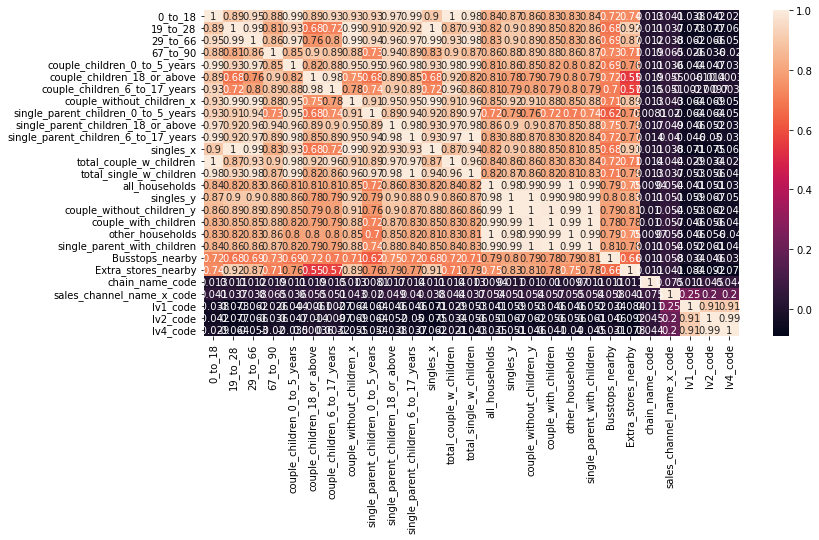

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset=pd.read_csv('train_combined_data.csv')

# finding the correlation
corrMatrix = dataset.corr()

# size of the plot
plt.figure(figsize=(12, 6))

# correaltion matrix
sns.heatmap(corrMatrix, annot=True)
plt.show()

## 3 Fitting models and predicting

Scaling the data: despite scaling the data, we have found no improvement in evaluating our models.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [21]:
X = stores_with_hierarchy.drop(['store_id', 'grunnkrets_id', 'revenue','sales_channel_name_x','chain_name','centroids_nearby','lv1','lv2','lv4'], axis = 1)
#X.rename(columns={'chain_name_code':'chain_name_code_x'},inplace = True)
y = stores_with_hierarchy['revenue']  # Target
X_test = stores_test.drop(['store_id', 'grunnkrets_id', 'chain_name','sales_channel_name_x','lv1','lv2','lv4'], axis = 1)

### 3.1 SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
regr.fit(X, y)
Y_pred = regr.predict(X_test)  # test the output by changing value

In [ ]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('SVMNodummies_guille.csv', index=False)

### 3.2 XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split # for splitting the data
xg_reg = xgb.XGBRegressor(objective ='reg:absoluteerror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X, y)

Y_pred = xg_reg.predict(X_test)

In [ ]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('XGBoostNodummies_guille.csv', index=False)

### 3.3 Bagging (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression


regr = BaggingRegressor(base_estimator=SVR(),
                         n_estimators=10, random_state=0).fit(X, y)
Y_pred = regr.predict(X_test)

In [ ]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('Bagging_guille1.csv', index=False)

### 3.4 Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(X, y) 

# Predicting the target values of the test set
Y_pred = model.predict(X_test)

In [ ]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('RandomForest_guille6.csv', index=False)

### 3.5 GridSearchCV (GradientBoostingRegressor)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


In [ ]:
GBR = GradientBoostingRegressor(learning_rate = 0.01,
                  subsample = 0.5,
                  n_estimators = 100,
                  max_depth = 4)

GBR.fit(X,y)

Y_pred = GBR.predict(X_test)

In [ ]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('GBR_2.csv', index=False)

### 3.6 lightgbm

In [59]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

X = stores_train[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']] #,'store_name'
X = X.astype('category')
y = stores_train['revenue']  # Target
X_test = stores_test[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']]
X_test = X_test.astype('category')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True) 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=50)


# prediction
y_pred = model.predict(x_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l1: 7.66184	valid_0's l2: 206.834
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 7.25337	valid_0's l2: 187.931
[3]	valid_0's l1: 6.89515	valid_0's l2: 171.988
[4]	valid_0's l1: 6.5868	valid_0's l2: 158.844
[5]	valid_0's l1: 6.32726	valid_0's l2: 148.068
[6]	valid_0's l1: 6.10216	valid_0's l2: 139.186
[7]	valid_0's l1: 5.90614	valid_0's l2: 131.922
[8]	valid_0's l1: 5.73562	valid_0's l2: 125.936
[9]	valid_0's l1: 5.59253	valid_0's l2: 121.39
[10]	valid_0's l1: 5.46942	valid_0's l2: 117.446
[11]	valid_0's l1: 5.37094	valid_0's l2: 114.589
[12]	valid_0's l1: 5.28157	valid_0's l2: 112.103
[13]	valid_0's l1: 5.20392	valid_0's l2: 109.935
[14]	valid_0's l1: 5.14312	valid_0's l2: 108.35
[15]	valid_0's l1: 5.09115	valid_0's l2: 107.064
[16]	valid_0's l1: 5.04542	valid_0's l2: 105.931
[17]	valid_0's l1: 5.00853	valid_0's l2: 105.097
[18]	valid_0's l1: 4.97486	valid_0's l2: 104.406
[19]	valid_0's 

### Prediction kaggle score --> 0.80846

In [64]:
X = stores_train[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']] #,'store_name'
X = X.astype('category')
y = stores_train['revenue']  # Target
X_test = stores_test[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']]
X_test = X_test.astype('category')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True) 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=50)

# prediction
Y_pred = model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l1: 7.60503	valid_0's l2: 175.612
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 7.19142	valid_0's l2: 156.282
[3]	valid_0's l1: 6.8361	valid_0's l2: 140.856
[4]	valid_0's l1: 6.53233	valid_0's l2: 128.041
[5]	valid_0's l1: 6.26908	valid_0's l2: 117.578
[6]	valid_0's l1: 6.04877	valid_0's l2: 109.229
[7]	valid_0's l1: 5.857	valid_0's l2: 102.396
[8]	valid_0's l1: 5.69026	valid_0's l2: 96.9182
[9]	valid_0's l1: 5.54915	valid_0's l2: 92.5907
[10]	valid_0's l1: 5.43353	valid_0's l2: 89.0653
[11]	valid_0's l1: 5.33131	valid_0's l2: 86.2193
[12]	valid_0's l1: 5.24534	valid_0's l2: 84.0162
[13]	valid_0's l1: 5.1696	valid_0's l2: 82.26
[14]	valid_0's l1: 5.10738	valid_0's l2: 80.8825
[15]	valid_0's l1: 5.05599	valid_0's l2: 79.8142
[16]	valid_0's l1: 5.00923	valid_0's l2: 78.9701
[17]	valid_0's l1: 4.97052	valid_0's l2: 78.3929
[18]	valid_0's l1: 4.9368	valid_0's l2: 77.8994
[19]	valid_0's l1: 

In [67]:
prediction = pd.DataFrame()
prediction['id'] = stores_test.store_id
prediction['predicted'] = Y_pred
prediction.to_csv('lightgbm_categoricalf_late1.csv', index=False)


### Trying to improve the lightgbm
We have tried to improve the model that has given us a better result, although this has not happened. This may be due to the loss of information from the converted variables.

In [88]:

X = stores_train[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']] #,'store_name'
X = X.astype('category')
X["lv4"] = stores_with_hierarchy['lv4_code']
y = stores_train['revenue']  # Target
X_test = stores_test[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']]
X_test = X_test.astype('category')

#encoding for LV4
X_test["lv4"] = [stores_test.plaace_hierarchy_id[i][0:7] for i in range(len(stores_test))]
unique_lv4_test = X_test['lv4'].unique()
lv4_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv4_test))])
X_test['lv4'] = X_test['lv4'].apply(lambda x: lv4_map_test[x])


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True) 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=50)

# prediction
Y_pred = model.predict(x_test)


# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\guill\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l1: 7.74231	valid_0's l2: 203.246
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 7.34061	valid_0's l2: 183.725
[3]	valid_0's l1: 6.9871	valid_0's l2: 167.632
[4]	valid_0's l1: 6.67051	valid_0's l2: 154.217
[5]	valid_0's l1: 6.38732	valid_0's l2: 142.919
[6]	valid_0's l1: 6.14678	valid_0's l2: 133.768
[7]	valid_0's l1: 5.93966	valid_0's l2: 126.451
[8]	valid_0's l1: 5.76243	valid_0's l2: 120.356
[9]	valid_0's l1: 5.61341	valid_0's l2: 115.604
[10]	valid_0's l1: 5.48856	valid_0's l2: 111.646
[11]	valid_0's l1: 5.38125	valid_0's l2: 108.287
[12]	valid_0's l1: 5.29323	valid_0's l2: 105.7
[13]	valid_0's l1: 5.21871	valid_0's l2: 103.526
[14]	valid_0's l1: 5.15087	valid_0's l2: 101.627
[15]	valid_0's l1: 5.09459	valid_0's l2: 100.18
[16]	valid_0's l1: 5.04535	valid_0's l2: 98.9932
[17]	valid_0's l1: 5.00159	valid_0's l2: 98.023
[18]	valid_0's l1: 4.96805	valid_0's l2: 97.2007
[19]	valid_0's l1

### Trying to improve the lightgbm II

In [77]:
test_19_28 = stores_test['19_to_28']
other_h = stores_test['other_households']
all_h = stores_test['all_households']
other_h = stores_test['other_households']
couple_with_ch = stores_test['couple_with_children']

In [78]:
stores_train_lat_lon=stores_train[['lat','lon']]
l=[]
for p in range(len(stores_train_lat_lon)):
    tupla=tuple(stores_train_lat_lon.iloc[p])
    l.append(tupla)
import geopy.distance

Trondheim_torg=(63.43005, 10.393475)

disttrondt=[]
for i in range(len(stores_train_lat_lon)):
    k=geopy.distance.great_circle(Trondheim_torg, l[i]).km                          
    disttrondt.append(k)

In [82]:
stores_test_lat_lon=pd.read_csv('data/stores_test.csv')[['lat','lon']]
li=[]
for pi in range(len(stores_test_lat_lon)):
    tuplas=tuple(stores_test_lat_lon.iloc[pi])
    li.append(tuplas)
import geopy.distance

Trondheim_torg=(63.43005, 10.393475)

disttrondt2=[]
for ip in range(len(stores_test_lat_lon)):
    ki=geopy.distance.great_circle(Trondheim_torg, li[ip]).km                          
    disttrondt2.append(ki)

In [83]:
## from sklearn import preprocessing

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_train['chain_name'].fillna('LOCAL STORE', inplace=True)
stores_test['chain_name'].fillna('LOCAL STORE', inplace=True)


X = stores_train[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']] #,'store_name'

le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()
le4 = preprocessing.LabelEncoder()
le.fit(X.chain_name)
le2.fit(X.sales_channel_name)
le3.fit(X.plaace_hierarchy_id)
le4.fit(X.store_name)

X['chain_name'] = le.transform(X.chain_name)
X['sales_channel_name'] = le2.transform(X.sales_channel_name)
X['plaace_hierarchy_id'] = le3.transform(X.plaace_hierarchy_id)
X['store_name'] = le4.transform(X.store_name)
#X['extra_stores_2km'] = xtrstnearby
#X['busstops_2km'] = busstopsnearby
X['dist_trondheim_torg'] = disttrondt
#X['19_to_28'] = stores_with_hierarchy['19_to_28']


y = stores_train['revenue']  # Target


X_test = stores_test[['chain_name','sales_channel_name', 'plaace_hierarchy_id','store_name']]

#le = preprocessing.LabelEncoder()
#le2 = preprocessing.LabelEncoder()
#le3 = preprocessing.LabelEncoder()
#le4 = preprocessing.LabelEncoder()
le.fit(X_test.chain_name)
le2.fit(X_test.sales_channel_name)
le3.fit(X_test.plaace_hierarchy_id)
le4.fit(X_test.store_name)

X_test['chain_name'] = le.transform(X_test.chain_name)
X_test['sales_channel_name'] = le2.transform(X_test.sales_channel_name)
X_test['plaace_hierarchy_id'] = le3.transform(X_test.plaace_hierarchy_id)
X_test['store_name'] = le4.transform(X_test.store_name)
#X_test['extra_stores_2km'] = xtrstnearby2l
#X_test['busstops_2km'] = busstopsnearby2
X_test['dist_trondheim_torg'] = disttrondt2

C:\Users\lcgsa\AppData\Local\Temp\ipykernel_10616\3097766547.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['chain_name'] = le.transform(X.chain_name)
C:\Users\lcgsa\AppData\Local\Temp\ipykernel_10616\3097766547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sales_channel_name'] = le2.transform(X.sales_channel_name)
C:\Users\lcgsa\AppData\Local\Temp\ipykernel_10616\3097766547.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [84]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_train['chain_name'].fillna('LOCAL STORE', inplace=True)
stores_test['chain_name'].fillna('LOCAL STORE', inplace=True)


X = stores_train[['chain_name','sales_channel_name','store_name', 'plaace_hierarchy_id']] #,'store_name', 'plaace_hierarchy_id'
X = X.astype('category')
X['dist_trondheim_torg'] = disttrondt
X['extra_stores_2km'] = xtrstnearby
X['busstops_2km'] = busstopsnearby
X['19_to_28'] = stores_with_hierarchy['19_to_28']
#X['other_households'] = stores_with_hierarchy['other_households']
#X['all_households'] = stores_with_hierarchy['all_households']
#X['couple_with_children'] = stores_with_hierarchy['couple_with_children']



y = stores_train['revenue']  # Target

X_test = stores_test[['chain_name','sales_channel_name','store_name', 'plaace_hierarchy_id']] #'store_name', 'plaace_hierarchy_id'
X_test = X_test.astype('category')
X_test['dist_trondheim_torg'] = disttrondt2
X_test['extra_stores_2km'] = xtrstnearby2
X_test['busstops_2km'] = busstopsnearby2
X_test['19_to_28'] = test_19_28 
#X_test['other_households'] = other_h
#X_test['all_households'] = all_h
#X_test['couple_with_children'] = couple_with_ch


'''#encoding for LV4
X_test["lv4"] = [stores_test.plaace_hierarchy_id[i][0:7] for i in range(len(stores_test))]
unique_lv4_test = X_test['lv4'].unique()
lv4_map_test = dict([(y, x+1) for x, y in enumerate(sorted(unique_lv4_test))])
X_test['lv4'] = X_test['lv4'].apply(lambda x: lv4_map_test[x])'''


import lightgbm as lgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True) 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=100)


# prediction
y_pred = model.predict(x_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 232.831	valid_0's l1: 7.9589
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 213.21	valid_0's l1: 7.56825
[3]	valid_0's l2: 196.959	valid_0's l1: 7.23366
[4]	valid_0's l2: 182.619	valid_0's l1: 6.92856
[5]	valid_0's l2: 171.054	valid_0's l1: 6.67286
[6]	valid_0's l2: 160.974	valid_0's l1: 6.45108
[7]	valid_0's l2: 152.911	valid_0's l1: 6.25705
[8]	valid_0's l2: 146.349	valid_0's l1: 6.0863
[9]	valid_0's l2: 140.766	valid_0's l1: 5.93828
[10]	valid_0's l2: 136.21	valid_0's l1: 5.80046
[11]	valid_0's l2: 132.543	valid_0's l1: 5.68323
[12]	valid_0's l2: 129.388	valid_0's l1: 5.57979
[13]	valid_0's l2: 126.975	valid_0's l1: 5.49943
[14]	valid_0's l2: 125.028	valid_0's l1: 5.43322
[15]	valid_0's l2: 123.356	valid_0's l1: 5.36688
[16]	valid_0's l2: 122.046	valid_0's l1: 5.31203
[17]	valid_0's l2: 120.785	valid_0's l1: 5.25833
[18]	valid_0's l2: 119.713	valid_0's l1: 5.21139
[19]	valid_0's 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

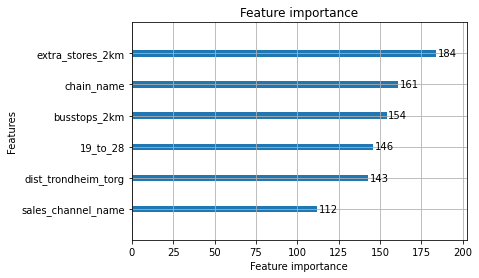

In [85]:
import lightgbm
lightgbm.plot_importance(model)

In [87]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_train['chain_name'].fillna('LOCAL STORE', inplace=True)
stores_test['chain_name'].fillna('LOCAL STORE', inplace=True)

X = stores_train[['chain_name','sales_channel_name','store_name', 'plaace_hierarchy_id']] #,'store_name', 'plaace_hierarchy_id'
X = X.astype('category')
X['dist_trondheim_torg'] = disttrondt
X['extra_stores_2km'] = xtrstnearby
X['busstops_2km'] = busstopsnearby
X['19_to_28'] = stores_with_hierarchy['19_to_28']
#X['other_households'] = stores_with_hierarchy['other_households']
#X['all_households'] = stores_with_hierarchy['all_households']
#X['couple_with_children'] = stores_with_hierarchy['couple_with_children']



y = stores_train['revenue']  # Target

X_test = stores_test[['chain_name','sales_channel_name','store_name', 'plaace_hierarchy_id']] #'store_name', 'plaace_hierarchy_id'
X_test = X_test.astype('category')
X_test['dist_trondheim_torg'] = disttrondt2
X_test['extra_stores_2km'] = xtrstnearby2
X_test['busstops_2km'] = busstopsnearby2
X_test['19_to_28'] = test_19_28 
#X_test['other_households'] = other_h
#X_test['all_households'] = all_h
#X_test['couple_with_children'] = couple_with_ch

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True) 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=50)

# prediction
Y_pred = model.predict(X_test)

C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\lcgsa\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 187.131	valid_0's l1: 7.65052
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 168.579	valid_0's l1: 7.24458
[3]	valid_0's l2: 152.549	valid_0's l1: 6.90479
[4]	valid_0's l2: 139.992	valid_0's l1: 6.60991
[5]	valid_0's l2: 129.106	valid_0's l1: 6.34427
[6]	valid_0's l2: 120.27	valid_0's l1: 6.11315
[7]	valid_0's l2: 112.664	valid_0's l1: 5.91158
[8]	valid_0's l2: 107.3	valid_0's l1: 5.75744
[9]	valid_0's l2: 102.802	valid_0's l1: 5.62145
[10]	valid_0's l2: 98.9367	valid_0's l1: 5.50298
[11]	valid_0's l2: 95.6513	valid_0's l1: 5.39423
[12]	valid_0's l2: 93.5774	valid_0's l1: 5.31181
[13]	valid_0's l2: 91.7004	valid_0's l1: 5.24563
[14]	valid_0's l2: 89.9328	valid_0's l1: 5.18374
[15]	valid_0's l2: 88.4893	valid_0's l1: 5.12092
[16]	valid_0's l2: 87.341	valid_0's l1: 5.07456
[17]	valid_0's l2: 86.532	valid_0's l1: 5.03411
[18]	valid_0's l2: 85.8784	valid_0's l1: 4.99777
[19]	valid_0's l2

Finally, we have obtained our best model, with a score around 0.78 in kaggle.